In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.preprocessing import LabelEncoder

In [37]:
# Load dataset
ya = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

In [38]:
#First 5 rows of the dataset
ya.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [39]:
# Drop customerID column
ya.drop('customerID', axis=1, inplace=True)

In [52]:
# Convert TotalCharges to numeric
ya['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
ya['TotalCharges'].fillna(ya['TotalCharges'].median(), inplace=True)

In [53]:
# Encode categorical variables
label_encoders = {}
for col in ya.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    ya[col] = le.fit_transform(ya[col])
    label_encoders[col] = le

In [54]:
# Define features and target
X = ya.drop('Churn', axis=1)
y = ya['Churn']

In [55]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [56]:
# Initial model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [57]:
# Evaluation
print("Initial Accuracy:", accuracy_score(y_test, y_pred))
print("Initial Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Initial Accuracy: 0.7993374349266446
Initial Confusion Matrix:
 [[1406  133]
 [ 291  283]]


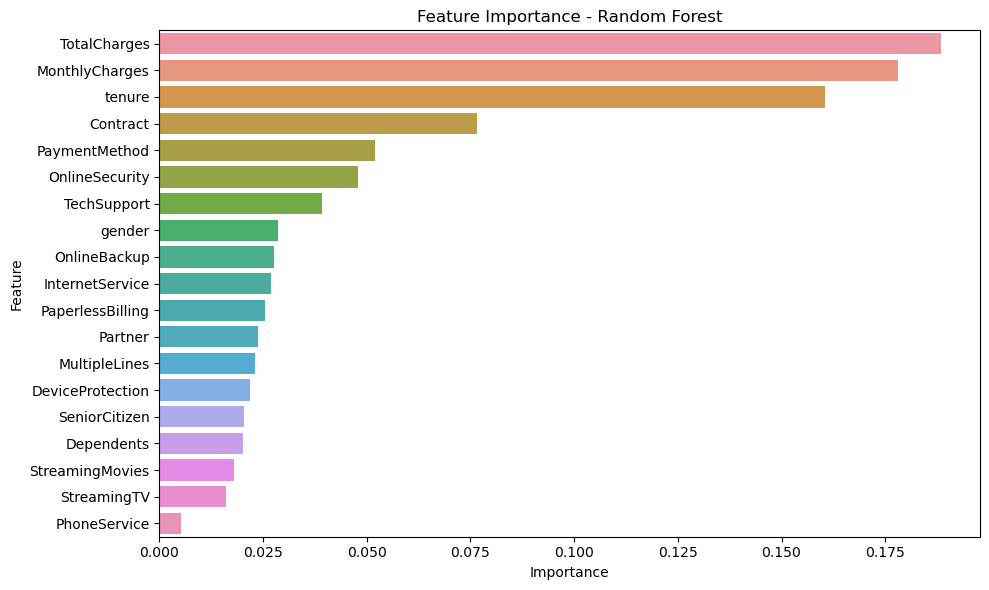

In [58]:
# Feature importance
importances = model.feature_importances_
features = X.columns
feature_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_df = feature_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_df)
plt.title('Feature Importance - Random Forest')
plt.tight_layout()
plt.show()


In [59]:
# Hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42),
                           param_grid,
                           cv=3,
                           scoring='accuracy',
                           verbose=1,
                           n_jobs=-1)

grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [50, 100]},
             scoring='accuracy', verbose=1)

In [60]:
# Best model
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)

In [61]:
# Evaluation
# print("Tuned Accuracy:", accuracy_score(y_test, y_pred_best)*100)
print(f"Tuned Accuracy: {accuracy_score(y_test, y_pred_best)*100:.2f}%")

print("Tuned Confusion Matrix:\n", confusion_matrix(y_test, y_pred_best))
print("Best Parameters:", grid_search.best_params_)


Tuned Accuracy: 79.98%
Tuned Confusion Matrix:
 [[1395  144]
 [ 279  295]]
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}


In [62]:
from sklearn.metrics import classification_report

# Print the classification report
print("Classification Report:\n", classification_report(y_test, y_pred_best))

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.91      0.87      1539
           1       0.67      0.51      0.58       574

    accuracy                           0.80      2113
   macro avg       0.75      0.71      0.73      2113
weighted avg       0.79      0.80      0.79      2113



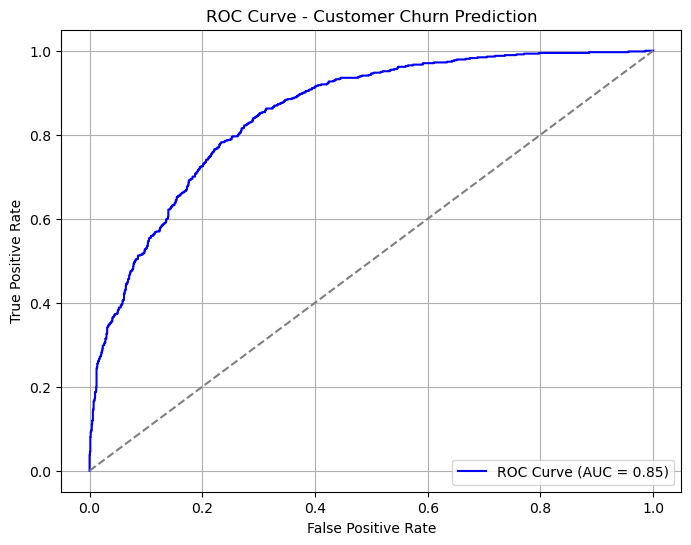

In [63]:
# ROC Curve
y_proba = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Customer Churn Prediction')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()